In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
import keras
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library

#Extra libraries for hog and pca
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from skimage import data
from skimage.color import (rgb2gray)

import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from IPython.display import clear_output

<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student numbers: <span style="color:red">r0703889, r0909802, r0716758, r0916443, r0822692</span>.

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 5 (either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2021 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------
This notebook is structured as follows:
0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. Provide strong arguments for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 


<div class="alert alert-block alert-info">
<b>NOTE:</b> This notebook is just a example/template, feel free to adjust in any way you please! Just keep things organised and document accordingly!
</div>

<div class="alert alert-block alert-info">
<b>NOTE:</b> Clearly indicate the improvements that you make!!! You can for instance use titles like: <i>3.1. Improvement: Non-linear SVM with RBF Kernel.<i>
</div>
    
---------------------------------------------------------------
# 0. Data loading & Preprocessing

## 0.1. Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

In [ ]:
# Input data files are available in the read-only "../input/" directory
# path kaggle
path = '/kaggle/input/computervision/'


train = pd.read_csv(
    '{}train_set.csv'.format(path), index_col = 0)
train.index = train.index.rename('id')

test = pd.read_csv(
    '{}test_set.csv'.format(path), index_col = 0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load('{}train/train_{}.npy'.format(path, index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load('{}test/test_{}.npy'.format(path, index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in test.iterrows()]
  

train_size, test_size = len(train),len(test)

"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 0.2. A first look
Let's have a look at the data columns and class distribution.

In [ ]:
# The training set contains an identifier, name, image information and class label
train.head()

In [ ]:
# The test set only contains an identifier and corresponding image information.

test.head(1)

In [ ]:
# The class distribution in the training set:
train.groupby('name').agg({'img':'count', 'class': 'max'})

Note that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data
### 0.3.1 Example: HAAR face detector
In this example we use the [HAAR feature based cascade classifiers](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect faces, then the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one. 

<div class="alert alert-block alert-info"> <b>NOTE:</b> You can write temporary files to <code>/kaggle/temp/</code> or <code>../../tmp</code>, but they won't be saved outside of the current session
</div>


In [ ]:
# parameter to play with 
# Set to 80x80 for the HOG feature extractor
FACE_SIZE = (80, 80)

The HAAR face detector tries to find faces in a image, when found, we resize the image to that particular face with a 100x100 square (or other sizes, we played around with the sizes and checked the outputs). However, it is possible that our train/test data contains multiple faces in one picture. The initial function took the first face it found and labeled that particular face with one of the classes (0, 1, 2). With this technique, the chances are high that the other person was taken to train our model, which is not interesting data to train and test an accurate model. 

In [ ]:
class HAARPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=7, #5
            minSize=(15, 15), #(30,30)
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

We made a new preproccessor which works as follows: All faces are extracted from a picture and we look at their probabilities to be the face of one of our actors. The one with the highest correlation, becomes extracted an resized.

In [ ]:
#problem when picture is zoomd in a lot
class Preprocessor():
    def __init__(self,face_size):
        self.face_size = face_size
        self.w = face_size[0]
        self.h= face_size[1]
#         file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
#         if not os.path.exists(file_path): 
#             if not os.path.exists(path):
#                 os.mkdir(path)
#             self.download_model(file_path)
        protoPath= "/kaggle/input/opencv-face-recognizer/deploy.prototxt"
        modelPath= "/kaggle/input/opencv-face-recognizer/res10_300x300_ssd_iter_140000.caffemodel"
        self.detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)
        
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        imageBlob = cv2.dnn.blobFromImage(
            cv2.resize(img, (300, 300)), 1.0, (300, 300),
            np.mean(img,axis=(0,1)), swapRB=False, crop=False)
        self.detector.setInput(imageBlob)
        return self.detector.forward()
        
#         img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         return self.classifier.detectMultiScale(
#             img_gray,
#             scaleFactor=1.3,
#             minNeighbors=5, #5
# #             minSize=(5, 5), #(30,30)
#             flags=cv2.CASCADE_SCALE_IMAGE
#         )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        detections = self.detect_faces(img)
        #TODO choose the right face
        if len(detections) > 0:
        # we're making the assumption that each image has only ONE
        # face, so find the bounding box with the largest probability
#             print(detections)
            i = np.argmax(detections[0, 0, :, 2])
            confidence = detections[0, 0, i, 2]
            
            (h, w) = img.shape[:2]
            
            box = detections[0, 0, i, 3:7] * np.array([w,h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            
#             else:
#                 

            # extract the face ROI and grab the ROI dimensions
            face = img[startY:endY, startX:endX]
            (fH, fW) = face.shape[:2]
            # ensure the face width and height are sufficiently large
            if  not (fW < 5 or fH < 5) and (confidence >0.5):  
#                 face = cv2.resize(face, (100,100),crop=True)
                return [face]
            else:
                return []
                
        else:
            return []
    

#             return [img[y-5:y+h+5, x-5:x+w+5] for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        # if no faces were found, return the full image cropped in face_size
        if len(faces) == 0:
#             nan_img = np.empty(self.face_size + (3,))
#             nan_img[:] = np.nan
            return cv2.resize(data_row['img'], self.face_size, interpolation = cv2.INTER_AREA)
        
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
    
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

In [ ]:
preprocessor = Preprocessor(face_size=FACE_SIZE)

**Visualise**

Let's plot a few examples.

In [10]:
def plot_image_sequence(data, n, imgs_per_row=7):
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
    for i in range(n):
        if n == 1:
            ax.imshow(data[i])
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i])
        else:
            ax[int(i%n)].imshow(data[i])
    plt.show()

    
#preprocessed data : changed 
# preprocessor = HAARPreprocessor(path = '../../tmp', face_size=FACE_SIZE)
preprocessor = Preprocessor(face_size=FACE_SIZE)

train_X, train_y = preprocessor(train), train['class'].values
test_X = preprocessor(test)



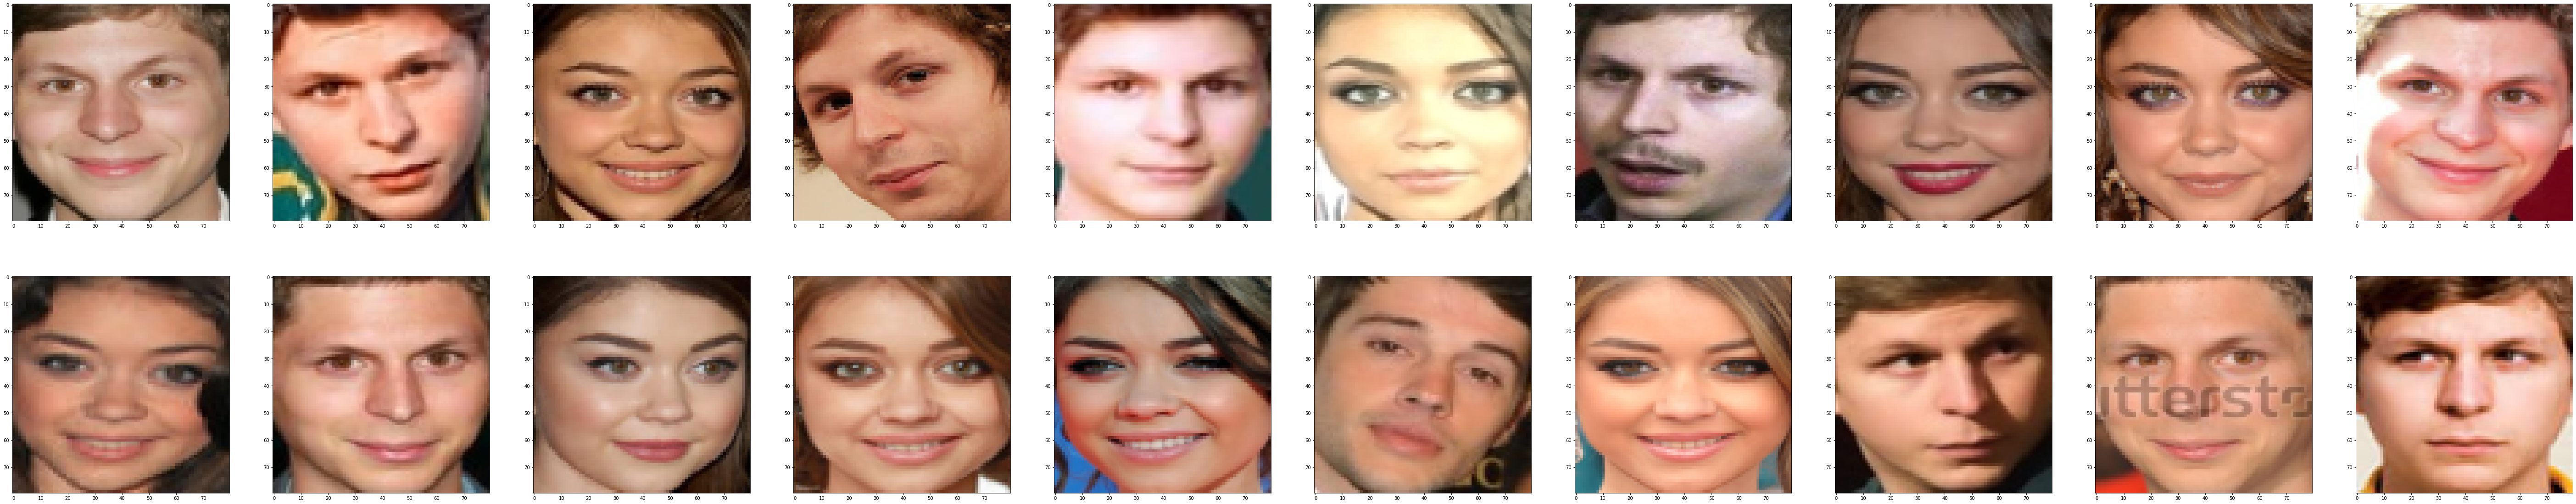

In [11]:
# plot faces of Michael and Sarah

plot_image_sequence(train_X[train_y == 0], n=20, imgs_per_row=10)

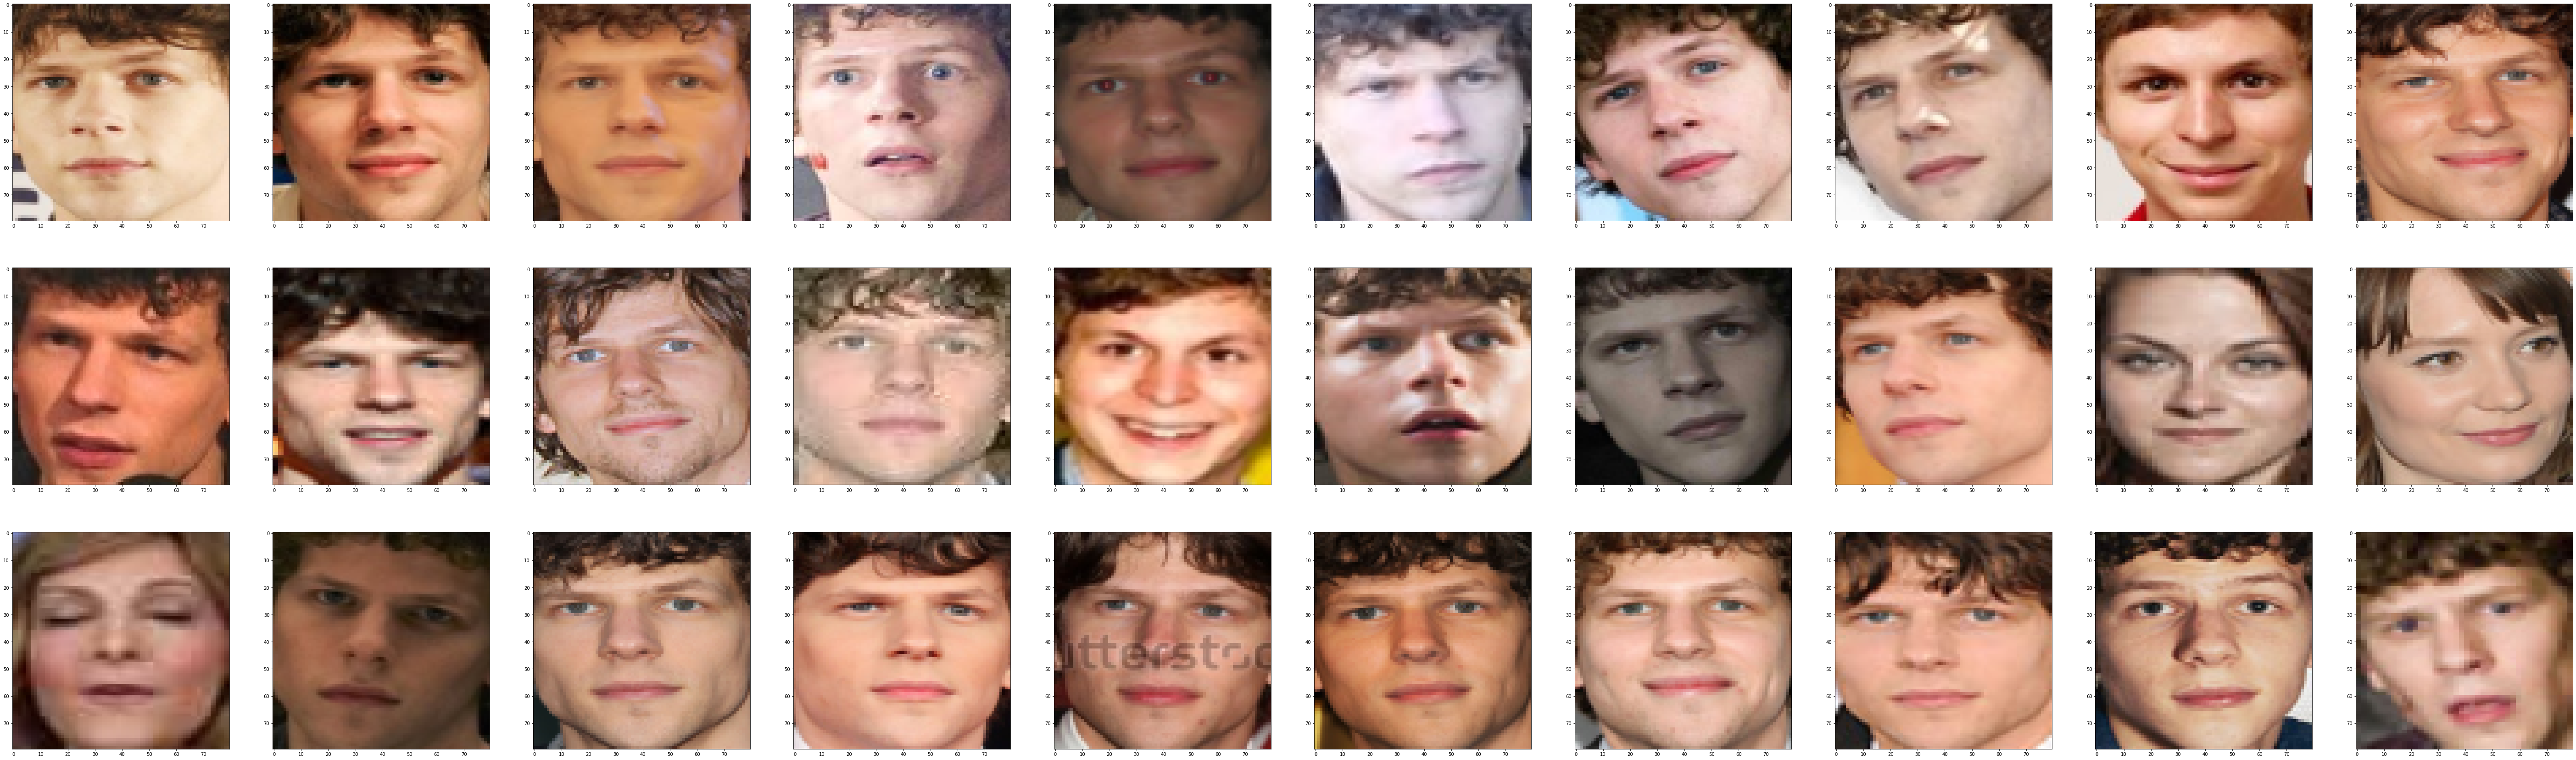

In [12]:
# plot faces of Jesse

plot_image_sequence(train_X[train_y == 1], n=30, imgs_per_row=10)

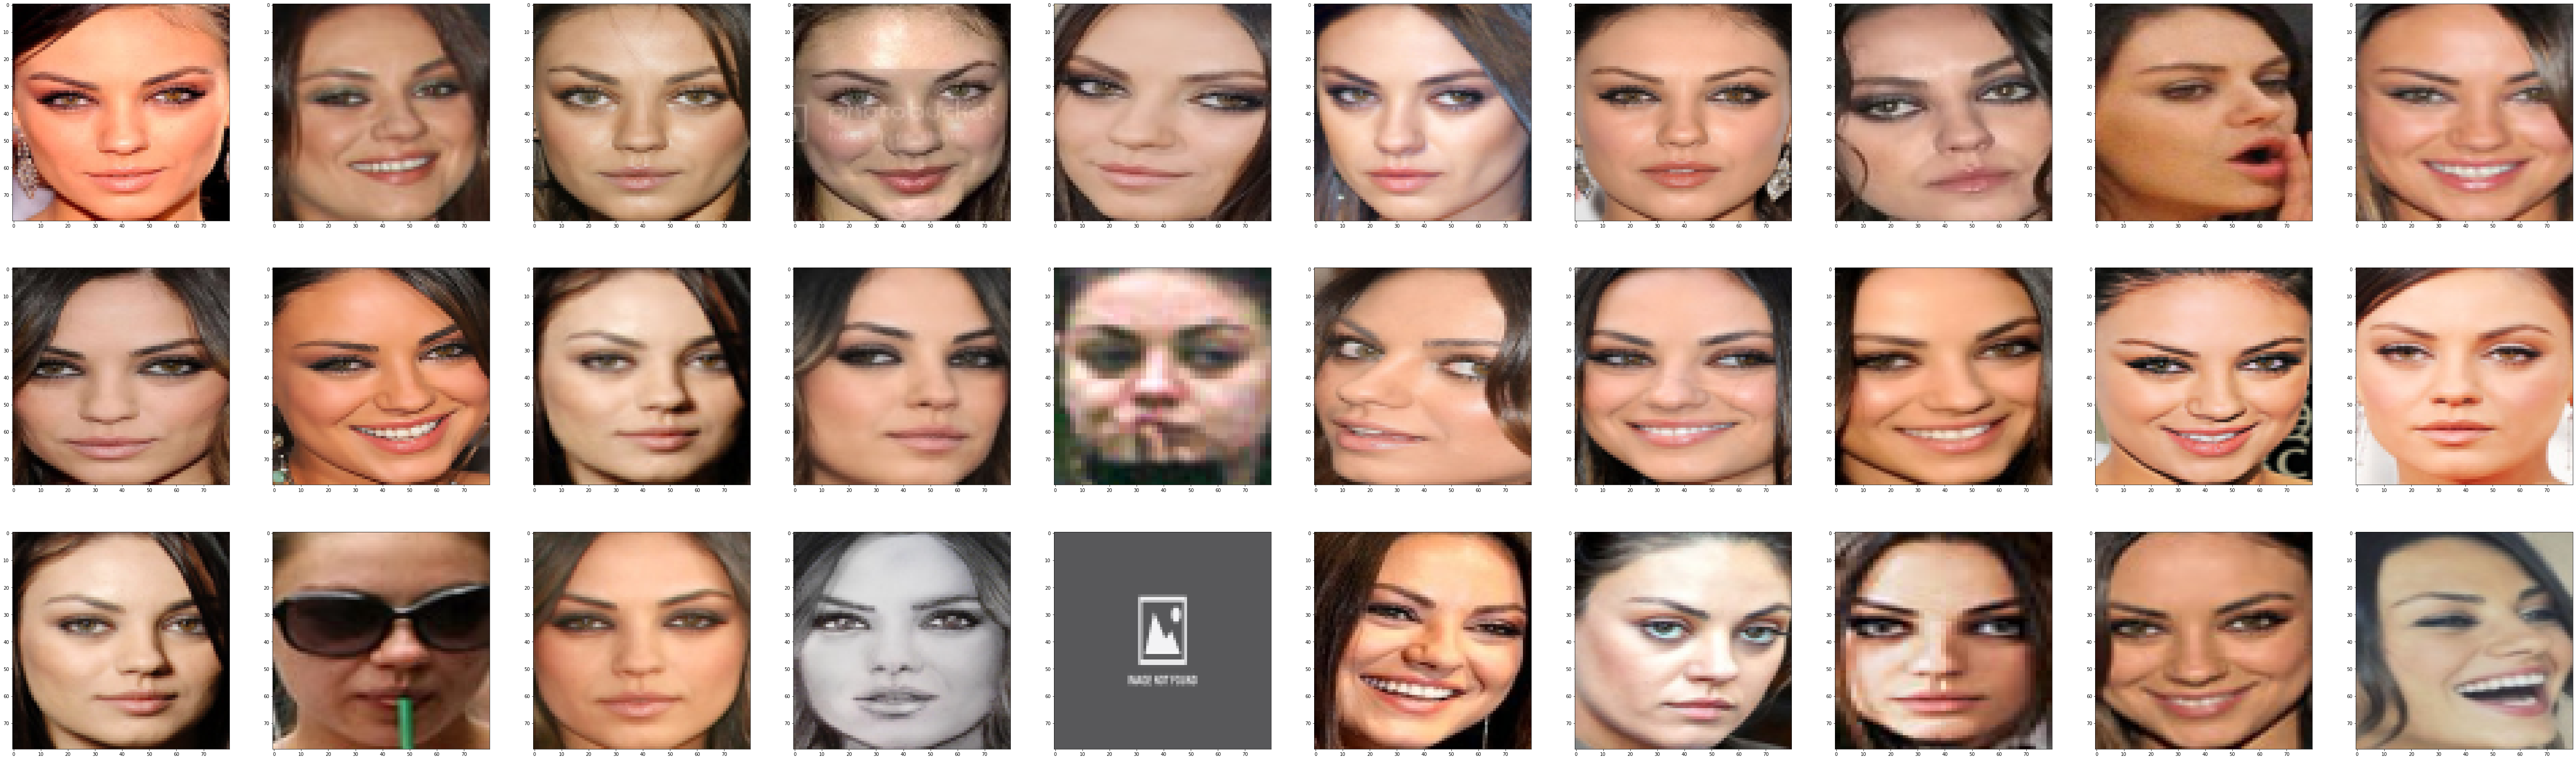

In [13]:
# plot faces of Mila

plot_image_sequence(train_X[train_y == 2], n=30, imgs_per_row=10)

## Data augmentation using prior knowledge
We can use the prior knowledge of this data set to generate new examples from the existing data set. These are the so called virtual examples. In this case we have to classify images of faces in three groups. Therefore if we for example mirror the images of the faces, they should remain in the same class. Using this method we can augment the data set with virtual examples.

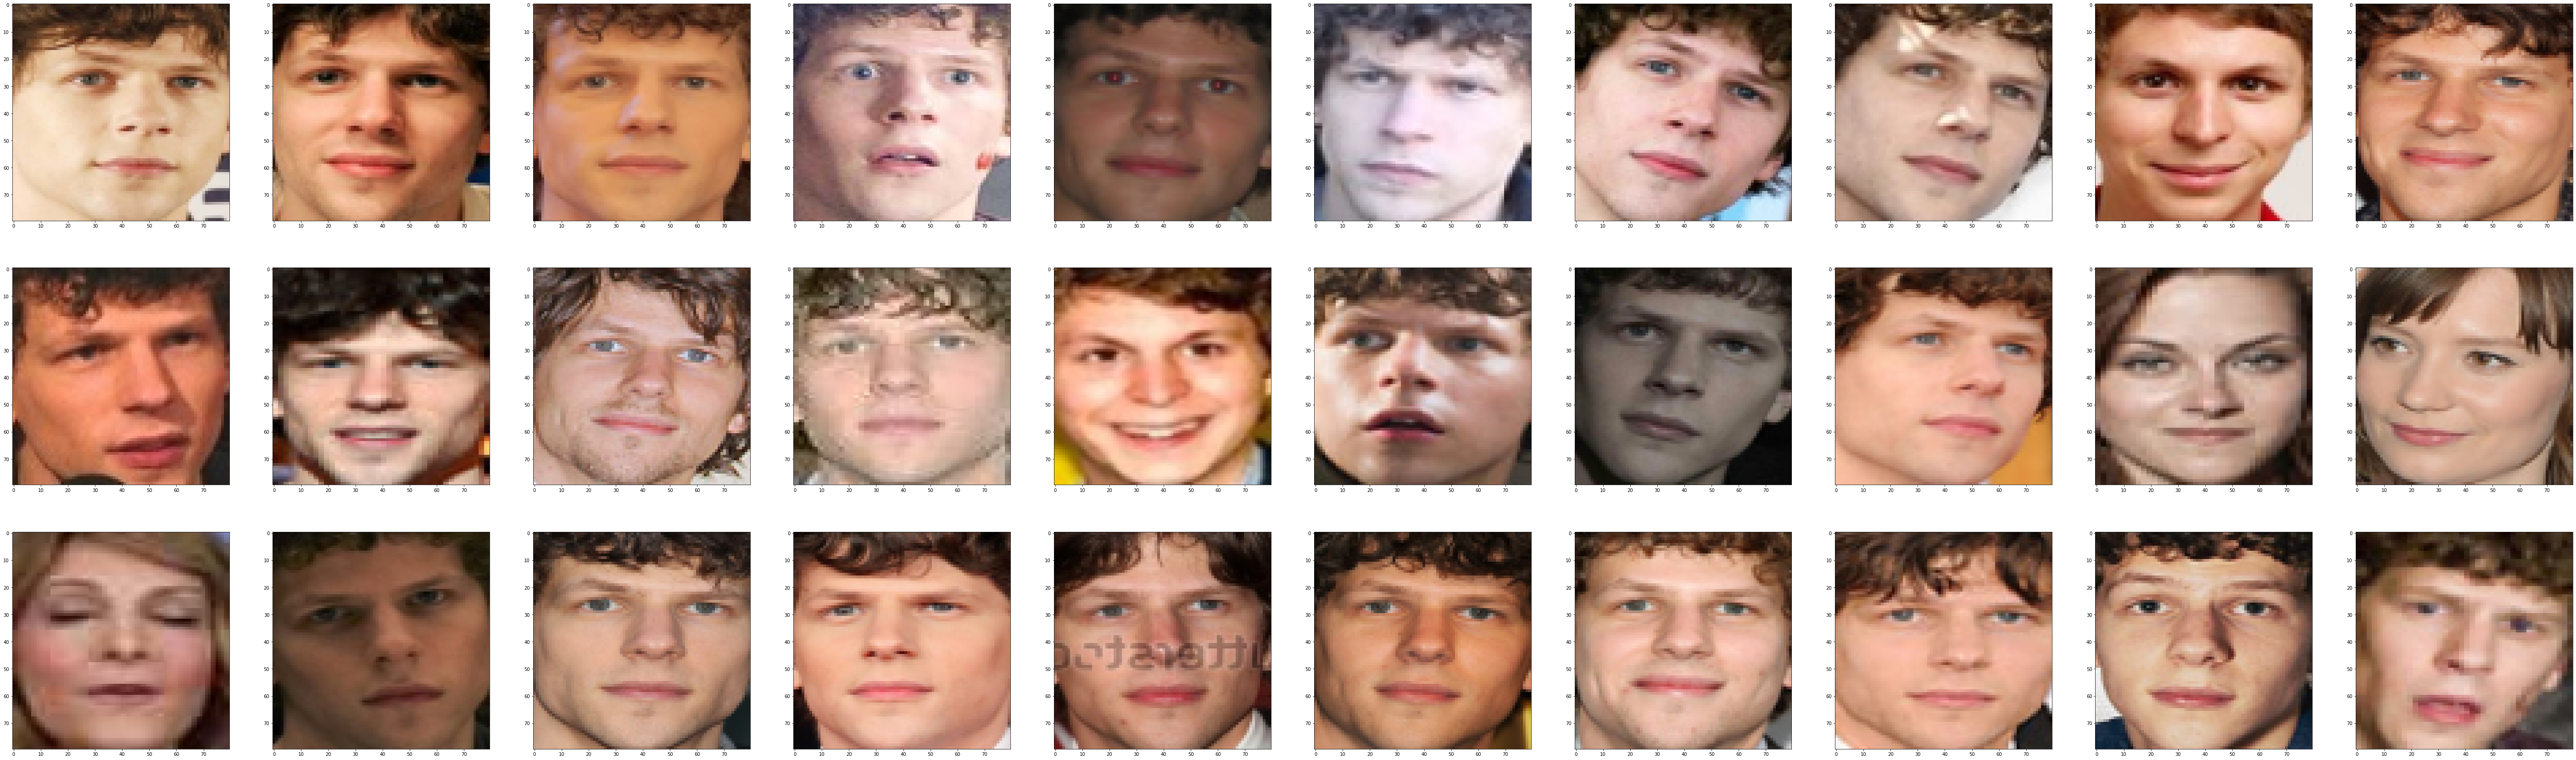

In [14]:
# mirroring examples Jesse
trainingExamplesJesse = train_X[train_y == 1]
n = 30
imgs_per_row = 10
n_rows = 1 + int(n/(imgs_per_row+1))
n_cols = min(imgs_per_row, n)
list_img_mirr = []
        
# creating mirror images
f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))

for i in range(n):
    img = trainingExamplesJesse[i]
    mirrored = np.fliplr(img)

    list_img_mirr.append(mirrored)

    if n == 1:
        ax.imshow(list_img_mirr[i])
    elif n_rows > 1:
        ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(list_img_mirr[i])
    else:
        ax[int(i%n)].imshow(list_img_mirr[i])

plt.show()  

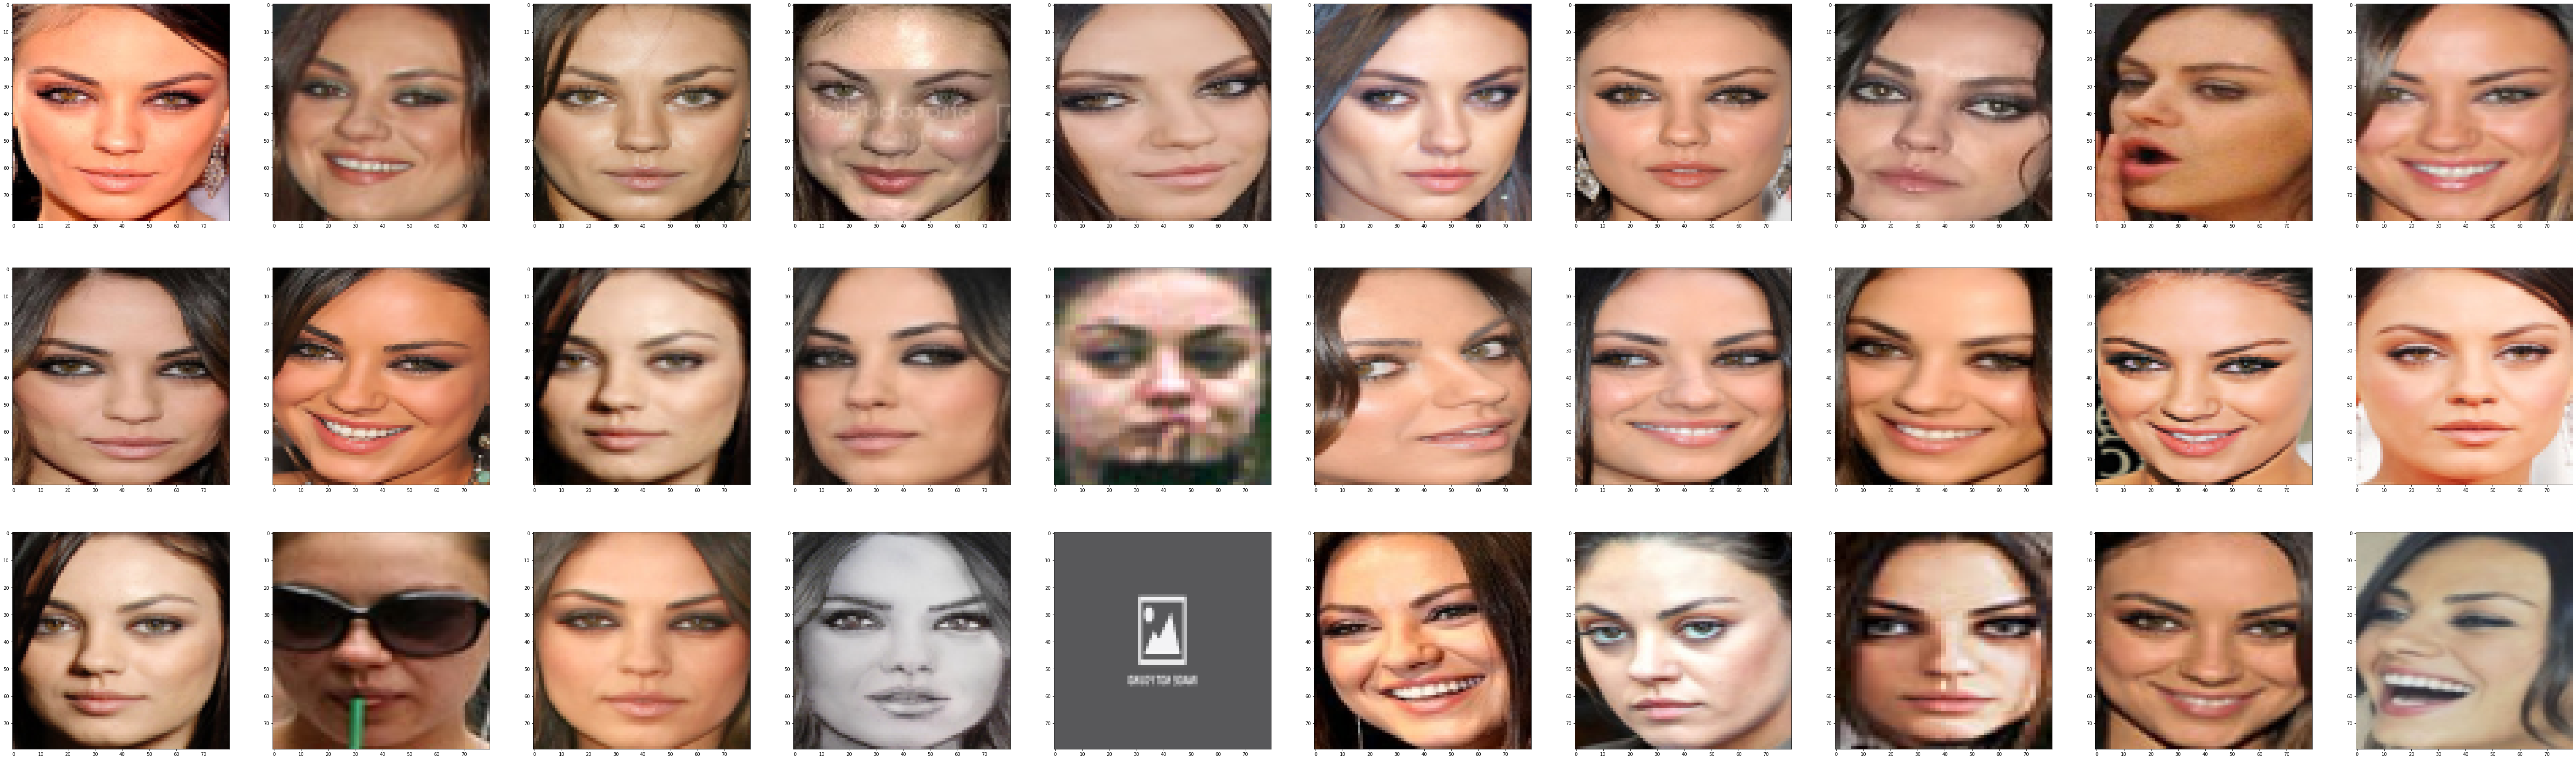

In [15]:
# mirroring examples Mila
trainingExamplesMila = train_X[train_y == 2]
n = 30
imgs_per_row = 10
n_rows = 1 + int(n/(imgs_per_row+1))
n_cols = min(imgs_per_row, n)
        
# creating mirror images
f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))

for i in range(n):
    img = trainingExamplesMila[i]
    mirrored = np.fliplr(img)

    list_img_mirr.append(mirrored)

    if n == 1:
        ax.imshow(list_img_mirr[30+i])
    elif n_rows > 1:
        ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(list_img_mirr[30+i])
    else:
        ax[int(i%n)].imshow(list_img_mirr[30+i])

plt.show()  

In [16]:
# removing unnecessary images
list_img_mirr.pop(0)
list_img_mirr.pop(5)
list_img_mirr.pop(10)
list_img_mirr.pop(12)
list_img_mirr.pop(33)
list_img_mirr.pop(49)

array([[[88, 88, 90],
        [88, 88, 90],
        [88, 88, 90],
        ...,
        [88, 88, 90],
        [88, 88, 90],
        [88, 88, 90]],

       [[88, 88, 90],
        [88, 88, 90],
        [88, 88, 90],
        ...,
        [88, 88, 90],
        [88, 88, 90],
        [88, 88, 90]],

       [[88, 88, 90],
        [88, 88, 90],
        [88, 88, 90],
        ...,
        [88, 88, 90],
        [88, 88, 90],
        [88, 88, 90]],

       ...,

       [[88, 88, 90],
        [88, 88, 90],
        [88, 88, 90],
        ...,
        [88, 88, 90],
        [88, 88, 90],
        [88, 88, 90]],

       [[88, 88, 90],
        [88, 88, 90],
        [88, 88, 90],
        ...,
        [88, 88, 90],
        [88, 88, 90],
        [88, 88, 90]],

       [[88, 88, 90],
        [88, 88, 90],
        [88, 88, 90],
        ...,
        [88, 88, 90],
        [88, 88, 90],
        [88, 88, 90]]])

In [ ]:
print(len(list_img_mirr))

In [ ]:
print(len(train_X))
newTrain_X = np.append(train_X, list_img_mirr, axis = 0)
print(len(newTrain_X))

In [ ]:
ones = np.repeat(1, 26)
twos = np.repeat(2,28)
newTrain_y = np.append(train_y, ones)
newTrain_y = np.append(newTrain_y, twos)
print(len(newTrain_y))

A second way to virtually augment the data, is by reducing the quality of the data. We can for example blur the images. This way of augmenting the data set works better than the mirroring technique. 

In [ ]:
# blurring examples Jesse
trainingExamplesJesse = train_X[train_y == 1]
n = 30
imgs_per_row = 10
n_rows = 1 + int(n/(imgs_per_row+1))
n_cols = min(imgs_per_row, n)
list_img_blurred = []
        
# creating mirror images
f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))

for i in range(n):
    img = trainingExamplesJesse[i]
    blurred = cv2.blur(img, (5,5))

    list_img_blurred.append(blurred)

    if n == 1:
        ax.imshow(list_img_blurred[i])
    elif n_rows > 1:
        ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(list_img_blurred[i])
    else:
        ax[int(i%n)].imshow(list_img_blurred[i])

plt.show()  

In [ ]:
# blurring examples Mila
trainingExamplesMila = train_X[train_y == 2]
n = 30
imgs_per_row = 10
n_rows = 1 + int(n/(imgs_per_row+1))
n_cols = min(imgs_per_row, n)
        
# creating mirror images
f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))

for i in range(n):
    img = trainingExamplesMila[i]
    blurred = cv2.blur(img, (5,5))

    list_img_blurred.append(blurred)

    if n == 1:
        ax.imshow(list_img_blurred[30+i])
    elif n_rows > 1:
        ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(list_img_blurred[30+i])
    else:
        ax[int(i%n)].imshow(list_img_blurred[30+i])

plt.show()  

In [ ]:
# removing unnecessary images
list_img_blurred.pop(0)
list_img_blurred.pop(5)
list_img_blurred.pop(10)
list_img_blurred.pop(12)
list_img_blurred.pop(33)
list_img_blurred.pop(49)

In [ ]:
print(len(train_X))
newTrain_X = np.append(train_X, list_img_blurred, axis = 0)
print(len(newTrain_X))

In [ ]:
ones = np.repeat(1, 26)
twos = np.repeat(2,28)
newTrain_y = np.append(train_y, ones)
newTrain_y = np.append(newTrain_y, twos)
print(len(newTrain_y))

## 0.4. Store Preprocessed data (optional)
<div class="alert alert-block alert-info">
<b>NOTE:</b> You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All". Feel free to use this to store intermediary results.
</div>

In [ ]:
# save preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
    
# np.save(os.path.join(prep_path, 'train_X.npy'), train_X)
# np.save(os.path.join(prep_path, 'train_y.npy'), train_y)
# np.save(os.path.join(prep_path, 'test_X.npy'), test_X)

# load preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
# train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
# train_y = np.load(os.path.join(prep_path, 'train_y.npy'))
# test_X = np.load(os.path.join(prep_path, 'test_X.npy'))

Now we are ready to rock!

# 1. Feature Representations
## 1.0. Example: Identify feature extractor
Our example feature extractor doesn't actually do anything... It just returns the input:
$$
\forall x : f(x) = x.
$$

It does make for a good placeholder and baseclass ;).

In [ ]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""
    
    def transform(self, X):
        return X
    
    def __call__(self, X):
        return self.transform(X)

## 1.1. Baseline 1: HOG feature extractor/Scale Invariant Feature Transform

HOG and SIFT are both very similar feature descriptors. 
However, the HOG feature extractor is used more frequently in classification problems than SIFT. The latter is used more in identificating specific objects. By this reason, we decided to implement the HOG feature extractor.


The HOG feature extractor counts occurences of gradient orientations in a localized portion of an image. The purpose of this technique to receive a better objects detection by focusing on the structure/shape of an object. This technique is widely used in computer vision and image processing, and was introducedin a research paper of Dala and Triggs in 2005.
This technique returns mostly sligtly better results than other edge descriptors because it also uses the magnitude and angle gradient to compute features, from which it generates an histogram.


In [ ]:
class HOGFeatureExtractor(IdentityFeatureExtractor):
    """
    https://www.thepythoncode.com/article/hog-feature-extraction-in-python

    """
    
    def __init__(self, X):
        self.X = X
        

    def save_extract(self):
        """         
         Saves images converted by HOG extractor
         
         Returns
         -------
         list_img : Array of arrays representing the Hog_images
        """
        n = self.X.shape
        list_img = []
        
        for i in range(n[0]):
            img = self.X[i]
            converted = np.float32(img)
            gray = cv2.cvtColor(converted, cv2.COLOR_BGR2GRAY)
            blur = cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT) # Gaussian Filtering
            fd, hog_image = hog(blur, orientations=10, pixels_per_cell=(5, 5), cells_per_block=(2, 2), block_norm="L2", visualize=True)

            list_img.append(hog_image)
        
        return list_img

    def plot_extract(self):
        n = self.X.shape
        imgs_per_row = 10
        n_rows = 1 + int(n[0]/(imgs_per_row+1))
        n_cols = min(imgs_per_row, n[0])
        list_img = []
        
        # creating hog features
        f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))

        for i in range(n[0]):
            img = self.X[i]
            converted = np.float32(img)
            gray = cv2.cvtColor(converted, cv2.COLOR_BGR2GRAY)
            blur = cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT) # Gaussian Filtering
            fd, hog_image = hog(blur, orientations=10, pixels_per_cell=(5, 5), cells_per_block=(2, 2), block_norm="L2", visualize=True)    

            list_img.append(hog_image)

            if n[0] == 1:
                ax.imshow(list_img[i])
            elif n_rows > 1:
                ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(list_img[i])
            else:
                ax[int(i%n[0])].imshow(list_img[i])

        plt.show()  


In [ ]:
hog_model = HOGFeatureExtractor(train_X)

# Save the extracted data to /kaggle/working
hog_model.save_extract()

# plot the extracted data as hog
hog_model.plot_extract()

### 1.1.1. t-SNE Plots
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a probabilistic, unsupervised, non-lineair technique used for data exploration to visualize higher dimensional data. It gives an intuitition on how the data is arranges in highter dimensions. This technique is relatively recent (2008), while PCA dates from 1933. The working is as follows: t-SNE tries to measure similarities between points in the high dimensional space and thereby uses a second set of probabilities, by using a student t-distribution. So finally, a gradient descend minimizes the cost function/diverence between the two distributions by measuring the pairwase similarities of low-dimensional points distribution and the distribution of input objects.

More technically explained, given N points -  $x_1,x_2,…,x_N$ in any dimension, t-SNE will compute the probability  $p_{i,j}$,  the probability of similarity of  $x_i$  and  $x_j$. In practice, given a cluster of N points, t-SNE will be a help in finding clusters with similarities in data points.

The parameters of a t-SNE are also optimisable. If the learning rate would be too high, the data will look lik a ball for example, with equispaced nearest neighbours. The parameters we finally have chosen, give a good picture on how seperable the data is.

In [ ]:
## Convert ImageData to a 2D matrix 
def set2Matrix(X):
    nb_train_images = len(X)
    size = FACE_SIZE[0]*FACE_SIZE[1]

    M = np.array(np.zeros([nb_train_images, size]))
    for n in range(nb_train_images):
        Im = X[n]
        A = np.asarray(Im).reshape(-1)
        M[n,:] = A
    return M

In [ ]:
df = hog_model.save_extract()

M_hog = set2Matrix(df)

tsne = TSNE(n_components=2, verbose=1, perplexity=30.0, learning_rate=100, n_iter=1000)

tsne_results = tsne.fit_transform(M_hog)

TSNE1 = tsne_results[:,0].tolist()
TSNE2 = tsne_results[:,1].tolist()


sns.scatterplot(x=TSNE1, y=TSNE2, hue=train['class'], palette=sns.color_palette("hls", 3), data=M_hog, legend="full").set(title='t-SNE plot')

### 1.1.2. Discussion
#### How to make your descriptor behave well in different circumstances (e.g. image with different lighting)
By simply **normalizing** the images with a 'L2' parameter, we **avoid brightness, contrast or other illumination effects**. This was done by adding `block_norm= ‘L2’` as a parameter of the HOG feature extractor. We could also have used L1 and L2-Hys as volunteering parameters. L2-Hys is sometimes used to reduce noise with the help of a L2-norm.


#### Comparison of this feature to the previous grabbing task in the individual assignment
The HOG feature extractor is a gradient based method and is generally known as a more robust method than the one we used in the individual assignment. In the individual assignment, the object grabbing was based on a **threshold of a particular colour**. The HOG feature extractor in contrary, uses the **magnitude and slope** to compute features. It is computed by dividing an entire image into smaller cells an summing up their gradients over every pixel within each cell in an image.


#### Pre-processing steps
First of all, we convert the images to a **grayscale** as a basement for the following steps. Then, before processing, the images have been **resized**. In the paper of Dalal and Triggs, dimensions 128x64 were advised. However, the size depends on the application. In the notebook, the images were already resized to 100x100 pixels. We tried to resize the images to 80x80, bit it gave worser results on the t-sne, so we kept te original proposed size. This was all done in the HAARpreprocessing phase.
Further, we **normalized** the images with a 'L2' parameter, **to avoid brightness, contrast or other illumination effects**. Other possible paramaters we could have used are L1 and L2-Hys. Finally, in order to take a few neighboring pixels into account instead of single pixel values as its true value, we performed a **Gaussian filtering**.

#### Discussion of missing values
In class 1 and 2, several black images appear. This means that the black images only contain 0 values, thus no information. Consequently, we can remove those images since they do not help our algorithm in classifying the faces correctly. 
Thereby, a few images which do not contain a face, are added to the training set.
In statistics, it is advised noy to throw away outliers unless we surely know that they are measurement errors. This is why we decided to keep these images in our dataset. Thereby, they can probably help us not to overfit certain parameters of a face. 


### Feature extraction

**Choice of hog features  and the visualisation of the feature Representation (t-SNE)**

There are many combinations of features that we could use for the HOG feature extractor. Unfortunately, the parameters are very data-specific, so we need data exploration. 

t-SNA gives a good representation on how destinguishable the classes are. We tried several modifications such as resizing the initial images and changing the parameters based on the resizement and played around with different combinations. Finally, the current setting seemed to have the most decent results in the t-sna plot. We clearly see a distinguashable difference between class 1 and 2, however, the data is not linearly seperable. Moreover, class 3 is somewhere in-between class 1 and 2 and difficult to do seperate from the other two classes. The initial trials had a cell size of 6-8pixels, based on an example of the following paper: [https://courses.engr.illinois.edu/ece420/fa2017/hog_for_human_detection.pdf](https://courses.engr.illinois.edu/ece420/fa2017/hog_for_human_detection.pdf).  The paper used a soft linear SVM model, so we will try this model in the classification part.
We can conclude that with the current setting, the results are good and discriminative for class 1 and 2, but not for class 0.

**t-SNE Plots**

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a probabilistic, unsupervised, non-lineair technique used for data exploration to visualize higher dimensional data. It gives an intuitition on how the data is arranges in highter dimensions. This technique is relatively recent (2008), while PCA dates from 1933. The working is as follows: t-SNE tries to measure similarities between points in the high dimensional space and thereby uses a second set of probabilities, by using a student t-distribution. So finally, a gradient descend minimizes the cost function/diverence between the two distributions by measuring the pairwase similarities of low-dimensional points distribution and the distribution of input objects.

More technically explained, given N points -  $x_1,x_2,…,x_N$ in any dimension, t-SNE will compute the probability  $p_{i,j}$,  the probability of similarity of  $x_i$  and  $x_j$. In practice, given a cluster of N points, t-SNE will be a help in finding clusters with similarities in data points.
The parameters of a t-SNE are also optimisable. If the learning rate would be too high, the data will look lik a ball for example, with equispaced nearest neighbours. The parameters we finally have chosen, give a good picture on how seperable the data is.

## 1.2. Baseline 2: PCA feature extractor
In this part we will extract feature with PCA. The central idea of principal component analysis (PCA) is to reduce the dimensionality of a data set consisting of a large number of interrelated variables, while retaining as much as possible of the variation present in the data set. This is achieved by transforming to a new set of variables, the principal components (PCs), which are uncorrelated, and which are ordered so that the first few retain most of the variation present in all of the original variables.
The code below consist first by defining the components we will choose for  the PCA, then fitting the model and doing the transformation and finally the inverse transformation from the feature the space to the complete space.

In [ ]:
#Preprocess images and convert Images to 2D matrix
def PreprocessPCA(X):
    n = X.shape[0]
    size = FACE_SIZE[0]*FACE_SIZE[1]
    M = np.zeros([n,size])
    for i in range(n):
        img = X[i]
        converted = np.float32(img)
        gray = cv2.cvtColor(converted, cv2.COLOR_BGR2GRAY) #Convert to Grayscale image
        blur = cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT) # Gaussian Filtering
        A = np.asarray(blur).reshape(-1)
        M[i,:] = A
    #Mean substraction
    M = M - M.mean(axis=1).reshape(M.shape[0], -1)
    return M

In [ ]:
#Visualisation of images form a 2D datamatrix
def plot_MatrixAsImages(title, images, n_col=3, n_row=5, cmap=plt.cm.gray):
    plt.figure(figsize=(2.0 * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(
            comp.reshape(FACE_SIZE),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.0)

In [ ]:
# from sklearn.decomposition import PCA
class PCAFeatureExtractor(IdentityFeatureExtractor):
    """TODO: this feature extractor is under construction"""
    
    def __init__(self, n_components):
        self.n_components = n_components
        self.estimator = PCA(n_components=self.n_components, svd_solver="randomized", whiten=True)
        
    def fit(self,X):
        self.estimator.fit(X)
        components = self.estimator.components_
        return components
        
    def transform(self, X):
        Xc = self.estimator.transform(X)
        return Xc
        

    def inverse_transform(self, X):
        Xc = self.estimator.inverse_transform(X)
        return Xc

### 1.2.1. Eigenface Plots
In this part we plot the eigenvector affiliated the vectors of the eigenvalue chosen for the PCA in order to have an idea about the information contained in the feature space. As the matrices are non squared we will use singular value decomposition for the PCA.
Moreover, the mean substraction is important to ensure that the first PC is proportional to the maximum variance of the input data.

The number of non zero singular value chosen is very important such that it contains 80% of the information in the data set. We will choose 12 component for our PCA.

**Reconstruction**:
In the visualisation, the 11th image from the training set is being reconstructed.
The reconstruction is done by gradually increasing the number of eigenfaces.
In the begin, larger difference between the reconstructed image are visible this because the first eigenvalues contains more information.
Closer to the end, almost no difference is visible. This eigenfaces consists almost no information.

In [ ]:
## Convert images to 2D matrix with preprocessing
M_pca = PreprocessPCA(train_X)

In [ ]:
#Nb non-zero singular values: 80% -> 6 components
PCA_N = PCAFeatureExtractor(M_pca.shape[0])
comp = PCA_N.fit(M_pca)
exp_var_pca = PCA_N.estimator.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

perc = 0.9
N = [ n for n,i in enumerate(cum_sum_eigenvalues) if i>perc ][0]
print('Nb of components for',perc*100,'% of variance:',N)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.axhline(y=perc, color='r', linestyle='-')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
PCA_Ncomp = PCAFeatureExtractor(N)
Ncomp = PCA_Ncomp.fit(M_pca)
Title = str(N)+' first eigenfaces' 
plot_MatrixAsImages(Title , Ncomp,10,8)
plt.show()

### 1.2.2. Feature Space Plots
Here we visualize the faces on the feature space using the first two principal components such that we could have an idea how is it distributed and to have an idea about
outliers such that we could remove it from the training set. As we have found some, thus the preprocessing in our data is important.
We could also notice that there is clusters of male and female and inside this two clusters different facial expressions.

In [ ]:
X_N = PCA_Ncomp.transform(M_pca)
Reconstruction = PCA_Ncomp.inverse_transform(X_N)
Y = np.matmul(M_pca, Ncomp[:2,:].T)


##Plot projected faces on the N-components on the feacture space
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
fig = plt.figure()
axes = fig.add_subplot(111)
plt.title("Face-Feature plot")
axes.scatter(Y[:,0],Y[:,1])
for i in range(M_pca.shape[0]):
    im = OffsetImage(Reconstruction[i,:].reshape(FACE_SIZE),zoom=0.3,cmap=plt.cm.gray)
    ab = AnnotationBbox(im, (Y[i,0],Y[i,1]), frameon=False)
    axes.add_artist(ab)

### 1.2.3. Discussion
**How to convert my image dataset to a 2D matrix?**
The set of images has to be represented by a matrix $M \in \mathbb{R}^{n\times m} $,
where n is the the number of images and m the number of pixels in each image.
Each image should be represented as a vector instead of a list.
Can you exploit the dimensionality of this matrix to make your computations more effective?
(As preprocessing outliers can be removed and some data augmentation can be done)
-> I don't know what they mean by that question

**Mean substraction or not?**
As mentioned before, the mean substraction is important to ensure that the first PC is propotionnal to the maximum variance of the input data.
Shall we use eigenvalue or singular value decomposition?
The data matrix is a non-square matrix. So, eigenvalue decomposition will not be possible.
Singular value decomposition is a more general case, that is applicable to non-squared matrices.
The computed singular values will be equal to the square roots of the eigenvalues of $M^*M$ or $MM^*$.

**How many non-zero eigenvalues/singularvalues should we have?**
Depending on the percentage of information that is desired, the number of components/singular values will change, the plot below show the variance contained in each eigenvector.
How might the choice of p influenced the performance of the features that you learned?
the more component we have the more information are contained in the feature. For 80% of information we should use in our our case 10 component.
Did you need any specific pre-processing steps before computing these feature descriptors on your images (which one and why)?
The same pre-processing steps as for HOG is done. This means the images are converted to gray-scale and are filtered through a Gaussian filter.
Did the visualisation show good discriminative and robustness properties?

In [ ]:
##Reconstruction

for i in range(1,81):
    PCA_recon = PCAFeatureExtractor(i)
    compR = PCA_recon.fit(M_pca)
    X_R = PCA_recon.transform(M_pca)
    Reconstruction = PCA_recon.inverse_transform(X_R)
    #Plot resinstruction of the 10th image
    clear_output(wait=True)
    plt.imshow(Reconstruction[10,:].reshape(FACE_SIZE[0],FACE_SIZE[1]),cmap=plt.cm.gray)
    Title = "Reconstruction with "+str(i)+" eigenfaces"
    plt.title(Title)
    plt.show()
    time.sleep(0.5)

# 2. Evaluation Metrics
## 2.0. Example: Accuracy
As example metric we take the accuracy. Informally, accuracy is the proportion of correct predictions over the total amount of predictions. It is used a lot in classification but it certainly has its disadvantages...

In [ ]:
from sklearn.metrics import accuracy_score

# 3. Classifiers
## 3.0. Example: The *'not so smart'* classifier
This random classifier is not very complicated. It makes predictions at random, based on the distribution obseved in the training set. **It thus assumes** that the class labels of the test set will be distributed similarly to the training set.

In [ ]:
class RandomClassificationModel:
    """Random classifier, draws a random sample based on class distribution observed 
    during training."""
    
    def fit(self, X, y):
        """Adjusts the class ratio instance variable to the one observed in y. 

        Parameters
        ----------
        X : tensor
            Training set
        y : array
            Training set labels

        Returns
        -------
        self : RandomClassificationModel
        """
        
        self.classes, self.class_ratio = np.unique(y, return_counts=True)
        self.class_ratio = self.class_ratio / self.class_ratio.sum()
        return self
        
    def predict(self, X):
        """Samples labels for the input data. 

        Parameters
        ----------
        X : tensor
            dataset
            
        Returns
        -------
        y_star : array
            'Predicted' labels
        """

        np.random.seed(0)
        return np.random.choice(self.classes, size = X.shape[0], p=self.class_ratio)
    
    def __call__(self, X):
        return self.predict(X)
    

## 3.1. Baseline 1: My favorite classifier
For each feature we tested multiple classifiers. The models which had the best results where the 'support vector machine' and the 'logistic regression' model. Both models got a score around 0.72 for the test set when used on the HOG feature representation. 

The model of each classifier is build by first transforming the input data to one of the feature representations. Then the building process for both feature representations is the same. First the model is trained on the trainingsdata by the function <model>.fit(). Then using this new fitted model, we can start classifiying the test data with the function <model>.predict().

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


class FavoriteClassificationModel():
    """TODO: this classifier is under construction."""
    def __init__(self,name):
        self.name=name
        if self.name == "SVM": #Support Vector Machine
            self.model = svm.SVC(kernel='linear', gamma='auto')
            
        elif self.name == "DT": #Decision Tree
            self.model = DecisionTreeClassifier()
            
        elif self.name == "LR": #Logistic regression
            self.model = LogisticRegression(random_state=0, max_iter=1000)
            
        elif self.name == "LR_OR": #Logistic regression One VS Rest
            LR = LogisticRegression()
            self.model = OneVsRestClassifier(LR)
         
        elif self.name == "Perceptron": #Perceptron
            self.model = Perceptron(tol=1e-3, random_state=0)
        
        elif self.name == "RC": #Ridge Classifier
            self.model =RidgeClassifier()
            
        elif self.name == "kNN": #k neighbors
            self.model = KNeighborsClassifier(leaf_size=1, p=2, n_neighbors=1)
            
        elif self.name == "RF": #Random Forest
            self.model = RandomForestClassifier(max_depth=2, random_state=0)
            
        else:
            print('No such a classifier')
        
    def fit(self, X, y):
         self.model.fit(X, y)
#         raise NotImplmentedError
        
    def predict(self, X):
        return self.model.predict(X)
#         raise NotImplmentedError

This cell below is a first test with the support vector machine on the trainingsdata with the HOG feature representation. First an test is done on only the images of Jesse and Mila. This results a score of 0.83. Then the same experiment is done but this time on all the trainingsdata (thus also the images of Michael and Sarah). The score when using all the trainingsdata is not as good. It has a score of 0.75. This is not suprising, since the faces of Michael and Sarah are similar to the ones of Jesse and Mila. This result was also already seen in the t-SNE plot above. There the blue and green dots (of Jesse and Mila) where mostly in disjunct clusters, whereas the red dots (of Michael and Sarah) where scattered through the plane, meaning the images of class zero are more difficult to distinguish.

In [ ]:
# comparison scores on training set between prediction of only Mila/Jesse and prediction with also the look-a-likes

from sklearn.model_selection import train_test_split

train_y_ones = np.repeat(1, 30)
train_y_twos = np.repeat(2, 30)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(train_X[train_y == 1], train_y_ones, test_size=0.2, random_state=0)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(train_X[train_y == 2], train_y_twos, test_size=0.2, random_state=0)
X_train = np.append(X_train_1, X_train_2, axis = 0)
y_train = np.append(y_train_1, y_train_2)
X_test = np.append(X_test_1, X_test_2, axis = 0)
y_test = np.append(y_test_1, y_test_2)

# show how it looks like
print('Train set:', X_train.shape)
print('Test set:', X_test.shape)

# HOG
feature_extractor_train = HOGFeatureExtractor(X_train)
feature_extractor_test = HOGFeatureExtractor(X_test)

hog_train = feature_extractor_train.save_extract()
hog_test = feature_extractor_test.save_extract()


# TRANSFORM TRAIN SET
M_hog_train = set2Matrix(hog_train)

# TRANSFORM TEST SET
M_hog_test = set2Matrix(hog_test)

# Testing performance on only Jesse/Mila
SVM_model = FavoriteClassificationModel("SVM")
SVM_model.fit(M_hog_train, y_train)
SVM_predict = SVM_model.predict(M_hog_test)
#SVM_score = SVM_model.score(M_hog_test, y_test)
print('score of SVM on only Jesse/Mila images: ' , accuracy_score(y_test, SVM_predict))

# Testing performance on also the look alikes
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=0)

# HOG
feature_extractor_train = HOGFeatureExtractor(X_train)
feature_extractor_test = HOGFeatureExtractor(X_test)

hog_train = feature_extractor_train.save_extract()
hog_test = feature_extractor_test.save_extract()


# TRANSFORM TRAIN SET
M_hog_train = set2Matrix(hog_train)

# TRANSFORM TEST SET
M_hog_test = set2Matrix(hog_test)

# Testing performance on only Jesse/Mila
SVM_model = FavoriteClassificationModel("SVM")
SVM_model.fit(M_hog_train, y_train)
SVM_predict = SVM_model.predict(M_hog_test)
#SVM_score = SVM_model.score(M_hog_test, y_test)
print('score of SVM on all images: ' , accuracy_score(y_test, SVM_predict))

# 4. Experiments
<div class="alert alert-block alert-info"> <b>NOTE:</b> Do <i>NOT</i> use this section to keep track of every little change you make in your code! Instead, highlight the most important findings and the major (best) pipelines that you've discovered.  
</div>
<br>

## 4.0. Example: basic pipeline
The basic pipeline takes any input and samples a label based on the class label distribution of the training set. As expected the performance is very poor, predicting approximately 1/4 correctly on the training set. There is a lot of room for improvement but this is left to you ;). 

In [ ]:
# HOG

# We are training on all the data.
feature_extractor_train = HOGFeatureExtractor(train_X)
feature_extractor_test = HOGFeatureExtractor(test_X)

hog_train = feature_extractor_train.save_extract()
hog_test = feature_extractor_test.save_extract()


# TRANSFORM TRAIN SET
M_hog_train = set2Matrix(hog_train)

# TRANSFORM TEST SET
M_hog_test = set2Matrix(hog_test)


In [ ]:
# PCA
# convert original data to the features

# TRANSFORM TRAIN SET
Train = PreprocessPCA(train_X)
PCA_FE = PCAFeatureExtractor(N)
comp = PCA_FE.fit(Train)
M_pca_train = PCA_FE.transform(Train)
# TRANSFORM TEST SET
Test = PreprocessPCA(test_X)
M_pca_test = PCA_FE.transform(Test)

In [ ]:
# DT Hog
DT_model = FavoriteClassificationModel("DT")
DT_model.fit(M_hog_train, train_y)
DT_predict = DT_model.predict(M_hog_test)

In [ ]:
# LR Hog
LR_model = FavoriteClassificationModel("LR")
LR_model.fit(M_hog_train, train_y)
LR_predict = LR_model.predict(M_hog_test)

In [ ]:
# SVM Hog
SVM_model = FavoriteClassificationModel("SVM")
SVM_model.fit(M_hog_train, train_y)
SVM_predict = SVM_model.predict(M_hog_test)

In [ ]:
# Perceptron Hog
PE_model = FavoriteClassificationModel("Perceptron")
PE_model.fit(M_hog_train, train_y)
PE_predict = PE_model.predict(M_hog_test)

In [ ]:
# RC Hog
RC_model = FavoriteClassificationModel("RC")
RC_model.fit(M_hog_train, train_y)
RC_predict = RC_model.predict(M_hog_test)

In [ ]:
# kNN Hog
neigh_model = FavoriteClassificationModel("kNN")
neigh_model.fit(M_hog_train, train_y)
neigh_predict = neigh_model.predict(M_hog_test)

In [ ]:
# RF Hog
RF_model = FavoriteClassificationModel("RF")
RF_model.fit(M_hog_train, train_y)
RF_predict = RF_model.predict(M_hog_test)

In [ ]:
# LR ONEVSREST PCA
LR_model_PCA = FavoriteClassificationModel("LR_OR")
LR_model_PCA.fit(M_pca_train, train_y)
LR_predict_pca = LR_model_PCA.predict(M_pca_test)

Check how many from each class

In [ ]:
Ty = DT_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

In [ ]:
Ty = SVM_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

In [ ]:
Ty = neigh_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

In [ ]:
Ty = LR_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

In [ ]:
Ty = PE_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

In [ ]:
Ty = RC_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

In [ ]:
Ty = RF_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

In [ ]:
Ty = LR_predict_pca.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)
##Score 0.61894

In [ ]:
# evaluate performance of the model on the training set
#train_y_star = model(train_X)

#train_y_star = model(X_train)
#train_y_star = model(M_hog_train)

#model(X_train)

#"The performance on the training set is {:.2f}. This however, does not tell us much about the actual performance (generalisability).".format(
#    accuracy_score(train_y, train_y_star))

In [ ]:
# predict the labels for the test set 
#test_y_star = model(X_test)
test_y_star = LR_predict

print(test_y_star)

In [ ]:
test_y_star = SVM_predict

print(test_y_star)

In [ ]:
test_y_star = neigh_predict

print(test_y_star)

In [ ]:
test_y_star = LR_predict

print(test_y_star)

In [ ]:
test_y_star = PE_predict

print(test_y_star)

In [ ]:
test_y_star = RC_predict

print(test_y_star)

In [ ]:
test_y_star = LR_predict_pca

print(test_y_star)

## 4.1 Improvements

#### Transfer learning

As knew in general, neural networks take a lot of resources train. With transfer learning, we make use of a pre-trained model, freeze it, and add some more layers to it and then only learn the upper layers for a particular face recognition. Imagine we trained a neural network on 5000 faces. The only thing we do is use that model and add the 3 additional faces we want to recognize. The model is trained only on the additional layer to recognize new faces.

Transfer learning is a popular method used in face recognition. It is an optimisation to save time and get better a performance. Since it is used in the context of deep learning, the first intuition would say that we need a lot of data, and this is something that was not provided initially in the training set. Here comes data augmentation into play. It is a method to enlarge the dataset by performing several transformations on your input data (e.g. flip, rotate, translation, scale, crop, ...) . However, transfer learning will make it possible to give decent results with smaller datasets, while a deep neural network would not.

Since our dataset is a part of the VGG dataset, we will try to use trainsfer learning based on the VGG16 model. The idea is to use this pre-trained model as base and add dense layers with our own pictures to train faster and more accurate

In [ ]:
# Transfer learning

from keras.applications import vgg16

img_rows, img_cols = 80,80

vgg = vgg16.VGG16(weights = 'imagenet', include_top = False, input_shape = (img_rows, img_cols, 3), pooling = 'avg')

#freeze the last 4 layers
for layer in vgg.layers:
    layer.trainable = False
    
#print layers
for (i, layer) in enumerate(vgg.layers):
    print(str(i) + "" + layer.__class__.__name__, layer.trainable)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
#from keras.layers.normalization import BatchNormalization
from keras.models import Model

In [ ]:
def lw(bottom_model, num_classes):
    """
    creates top/head of model that will be placed ontop of the bottom layers
    """
    top_model = bottom_model.output
#     top_model = GlobalAveragePooling2D()(top_model)
    #top_model = Dense(1024, activation='relu')(top_model)
    #top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(128, activation='relu')(top_model)
#     top_model = keras.layers.Dropout(0.2)(top_model)  # Regularize with dropout
    top_model = Dense(128, activation='relu')(top_model)
    top_model = keras.layers.Dropout(0.2)(top_model)  # Regularize with dropout
    top_model = Dense(64, activation='relu')(top_model)
    top_model = Dense(num_classes, activation='softmax')(top_model)
#     top_model = Dense(num_classes, activation='sigmoid')(top_model)
    return top_model

Since neural networks are more complicated models, we augment the data with the underneath technique. We realized that the accuracy becomes worser when we try to augment the data too much.

In [ ]:
# Data augmentation
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')
train_datagen.fit(train_X)
print(train_datagen)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
def dataaugmentation(x,y):
    Y = y.astype('int64')
    X = []
    for index, image in enumerate(x):
        classid = y[index]
        X.append(image)
        for i in range(20):
            new_img = train_datagen.random_transform(image)
            X.append(new_img)
            Y = np.append(Y, classid)
    return np.array(X),Y

In [ ]:
X, Y = dataaugmentation(X,Y)

In [ ]:
# split train/validation set
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2)

#cv2.resize(X_val,, interpolation = cv2.INTER_AREA)
X_val.shape

In [ ]:
print(X.shape)
print(Y.shape)

print(X_train.shape)
print(y_train.shape)

print(train_X.shape)

In [ ]:
plt.imshow(X_val[0])

In [ ]:
plt.imshow(train_datagen.random_transform(X_train[1]))

With the underneath code, we monitor the loss function and save only the best one. If the function did not improve after 5 iterations, we stop earlier. 

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("face recognisation.h5",
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                         min_delta=0,
                         patience=5,
                         verbose=1,
                         restore_best_weights = True)

# put call back into callback list
callbacks = [earlystop, checkpoint]

In [ ]:
num_classes = 3 # class 0,1,2

FC_Head = lw(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = FC_Head)
print(model.summary())

The output of the neural network contains 3 layers with each containing probabilities in it. we encode the output to 0’s and 1’s where we put a 1 in the argmax of every array (the class with the highest probability). This function is written 3x because the encoding had to be performed on the train, validation and testset.

In [ ]:
encoded_arr = []

# encoding 2 to [0 0 1]
for i in range(len(train_X)):
    if (Y[i]==2):
        m = np.array([0, 0, 1])
    elif(Y[i]==1):
        m = np.array([0, 1, 0])
    elif(Y[i]==0):
        m = np.array([1, 0, 0])
    encoded_arr.append(m)
    
encoded_arrayY = np.array(encoded_arr)
print(encoded_arrayY.shape)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model.compile(loss=keras.losses.CategoricalCrossentropy(),
             optimizer= keras.optimizers.Adam(),
             metrics=['accuracy'])

In [ ]:
encoded_arr_test = []

# encoding 2 to [0 0 1]
for i in range(len(y_val)):
    if (y_val[i]==2):
        m = np.array([0, 0, 1])
    elif(y_val[i]==1):
        m = np.array([0, 1, 0])
    elif(y_val[i]==0):
        m = np.array([1, 0, 0])
    #print(encoded_arr) 
    encoded_arr_test.append(m)
    
encoded_array_test = np.array(encoded_arr_test)
print(encoded_array_test)

In [ ]:
encoded_array = np.array(encoded_arr)

# Enter the number of training and validation samples here
nb_train_samples = 320
nb_validation_samples = 50

# We only train 30 EPOCHS , set to 25 in code
epochs = 3
batch_size = 64

print(model.summary())

model.fit(train_X, encoded_array, epochs=epochs, batch_size = batch_size, callbacks = callbacks, validation_data=(X_val,encoded_array_test))

In [ ]:
Finally, we compile our model and fit the results to predict the results.

In [ ]:
# use small learning rate
from tensorflow import keras
from tensorflow.keras import layers

model.compile(loss=keras.losses.CategoricalCrossentropy(),
             optimizer= keras.optimizers.Adam(),
             metrics=['accuracy'])

In [ ]:
print(train_X.shape)
print(val_X.shape)

In [ ]:
pred = np.argmax(model.predict(test_X),axis=1)

#### Data augmentation + prior knowledge
As discussed previously, we can use our prior knowledge of the model to augment the data with virtual examples. As the class stay invariant under transformation of the input. We tried to make virtual examples by mirroring the given training examples which did not result in good scores. Furthermore we tried to augment the data with blurred copies of the original images, these virtual examples resulted in better scores. However, the best score was reached with no augmented data

In [ ]:
# HOG on augmented data

# We are training on all the data.
feature_extractor_train_aug = HOGFeatureExtractor(newTrain_X)
feature_extractor_test = HOGFeatureExtractor(test_X)

hog_train_aug = feature_extractor_train_aug.save_extract()
hog_test = feature_extractor_test.save_extract()


# TRANSFORM TRAIN SET
M_hog_train_aug = set2Matrix(hog_train_aug)

# TRANSFORM TEST SET
M_hog_test = set2Matrix(hog_test)

In [ ]:
# LR Hog on augmented data
LR_model = FavoriteClassificationModel("LR")
LR_model.fit(M_hog_train_aug, newTrain_y)
LR_predict = LR_model.predict(M_hog_test)

In [ ]:
# SVM Hog augemented data
SVM_model = FavoriteClassificationModel("SVM")
SVM_model.fit(M_hog_train_aug, newTrain_y)
SVM_predict = SVM_model.predict(M_hog_test)

In [ ]:
Ty = SVM_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

In [ ]:
Ty = LR_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

In [ ]:
test_y_star = LR_predict

print(test_y_star)

In [ ]:
test_y_star = SVM_predict

print(test_y_star)

#### Loss function
Below, the loss function for the support vector machine is plotted. As can be seen on the plot, the MSE of the training set is really low. This is probably because there are too few examples to train from. Because there are so few examples the model can be overfitted. This means the model can perfectly fit the learned the example images, however it is not regularized. This results in the case where the model performs good on the training set, but far poorer on the test set. Therefore adding more data would probably result in better performance. 

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes = [1, 20, 40, 60, 80]

train_sizes, train_scores, validation_scores = learning_curve(svm.SVC(kernel='linear', gamma='auto'), M_hog_train , train_y, scoring = 'neg_mean_squared_error')

print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

print('\n', '-' * 70) # separator to make the output easy to read
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))



# TODO: WEGDOEN: REGRESSIE IPV CLASSIFICATIE
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(-0.2,2)

The loss curve in case of more trzining examples is plotted below. The gap between the validation error and the training error did become smaller, so there's less variance. However there is still some room for improvement. Adding more data can decrease the gap further. 

In [ ]:
train_sizes, train_scores, validation_scores = learning_curve(svm.SVC(kernel='linear', gamma='auto'), M_hog_train_aug , newTrain_y, scoring = 'neg_mean_squared_error')

print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

print('\n', '-' * 70) # separator to make the output easy to read
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(-0.2,1)

# 5. Publishing best results

In [ ]:
test_y_star = SVM_predict

submission = test.copy().drop('img', axis = 1)
submission['class'] = test_y_star

submission

In [ ]:
submission.to_csv('submission_SVM.csv')


# 6. Discussion
**Faces dataset**

A dataset of 80 images was provided in this assignment on which a classification has performed. The data is a subset of the VGG Face Dataset and the training set is classified in 3 classes: 30 images belong to Jesse Eisenberg, 30 images to Mila Kunis, and 20 images belong to look alikes (10 of Michael Cera and 10 of Sarah Hyland). The images are not ideal: sometimes there are other people on a picture next to our celebrity and the sizes of heads are also at random.


**HAAR classifier**

We started by pre-processing the data with a HAAR feature based cascade classifier. This is a relatively old algorithm compared to HOG feature detection (will be used in a later stage of the project), but still relatively fast and accurate, even in deep learning times. The HAAR Object Detection Algorithm is used to identify faces in images by edge or line detection features. The images have been rescaled to a size of 100x100, since this gave us the best results at the end. We tried to rescale to different sizes, since a paper of HOG proposed to change the size to a specific proportion, but this did not work out well at the end.

But black images still appeared which were classified faces of actors with the HAAR classifier, as well as images not containing faces. So we wrote a new preprocessor which gave us better accuracies by working with probabilities of faces, instead of selecting the first face it found. 

**Data augmentation using prior knowledge**

Since the initial training set is relatively small, we decided to experiment with data augmentation. By performing different operations on the data (mirror, rotate, ...), we can expand the initial dataset and make te model learn better in theory. The danger in using this technique, is the fact that augmentation has a regularization effect. Too much of this combined with other forms of regularization, for example dropouts (which we have tried in our neural network too), can cause a neural network to underfit. 
The accuracy of the most machine learning algorithms was not improved after performing a data augmentation.

**HOG feature extractor and t-SNE**

The purpose of HOG to receive a better objects detection by focusing on the structure/shape of an object. We had a choice between implementing a HOG and SIFT feature descriptor. Since HOG is used more in indentfying object, we decided to implement the HOG feature extractor.
t-SNE is a technique used for data exploration to visualize higher dimensional data. It gives an intuitition on how the data is arranges in highter dimensions. We performd t-SNE on the output data of the HOG feature extractor and noticed that class 1 and 2. are relatively seperable, but class 0 not.

**PCA**

We learned the theoretical workings of PCA and how to approximate an image using its principal components. By reducing the details of the image, it became possible to focus on the major differentiable parts of the image for classification. We use these two feature representation techniques for classification. 

**Discussion qualitative difference between HOG and PCA**

HOG and PCA are two feature extractors we have constructed. HOG outputs two outputs for every pixel (the gradient and magnitude), which gives a good insight in the existance of edges.
With PCA we try to get the most dominant features of the image. A classification based on PCA can be useful when the common dominant parts are known. HOG is useful in the context of a set of handcrafted features like a face for example.

**Classification**

We have used several different models and performed indepth analysis by plotting the learning curves and finetuning the hyperparameters. The models were tested on both PCA and HOG outputs. We started by implementing simple models such as decision trees an PLA. After some research, we discovered that SVM, Random Forest and KNN are the most appreciate models in combination with HOG. SVM worked indeed the best from the three and we finetuned the model with hyperparameter tuning and analyzed its learning curve to get the most out of it.

Further, we also experimented with Logistic Regression, which have the second best results, also based on HOG. We can conclude that the accuracy was in general better on images extracted with HOG than with PCA. 

**Improvements**

However, the results could have been improved. In general, it is known that more complicated models need more data, and we did not have a lot of data to experiment with. Since it was mentioned that the provided dataset was a subset of the VGG face set, we decided to experiment with transfer learning. We augmented the data with another library and used the VGG16 model from keras as a base on which transfer learning has been performed.

To our deep regret, the accuracy did not improved. Whe changed a lot of parameters in our model: changed the amount of layers, epochs, added Dropouts, analyzed the over/underfit, but the score did not get better than the one of SVM. Changing the amount of data which was augmented, did also not improve our accuracy (made it even worser).
On a certain point, the train validation was that good, that te accuracy of the validation set was 0.97, but it did not work that well on the real test set.
Since this model did not work very well, another attempt has been made. We trained 2 models, each on one one of the classes (trained on class 1 and 2). If the image was not classifiable with a high enough sureness, it went to class 0. This method was theoretically good, but did not receive a higher accuracy of 0.73, that we got before.

**Sub-optimallity of the performance**

There are several reasons why the performance of our classification is sub-obtimal. First of all, the training set is not perfectly clean: it contains black images as well as images which do not contain faces. This “noise” is removable from the training dataset, which we did, but it will still be difficult to classify these images to a certain class.

A second problem is the fact that the faces are not clearly distinguishable between the real actors, and the look-a-likes. As shown in the t-SNE plot, the original classes 1 and 2 are almost linearly seperable, although class 0 is not.
Further, the dataset is relatively small to learn: it is difficult to train an accurate deep learning model. Data augmentation is no panacea in this case: it makes highly correlated features, which we would like to avoid. By this reason our attempts to augment the data did not work.
It is possible that with PCA, the dominant features for a set of images is not the same when using the $n^{th}$ principal component.

**What we would have done better/more if we had plenty of time**

First of all, we could have done more in the the preprocessing step. The initial HAAR face detector was not optimal and we managed to extract the right faces more accurate, but we believe that there is much more to do with in that step. Further, we could have created more gradient from the background to have a more fixed idea about the dominant features of every image used in PCA. HOG was analysed indepth, but I think we still missed something because the final accuracy was not fantastic. At the end, we focused to much on a neural network instead of improving the preprocessing steps and the simpler algorithms. 

We still think that we could experiment by building our neural network based on PCA or train it in another way, but would have been better to have improved the preprocessing step much more, as well as focused more at the simpler algorithms such as SVM, OVO and gradient boosting.
